In [1]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import os, sys
sys.path.append(f"{os.path.dirname(os.getcwd())}/scripts")

In [2]:
# from creative_and_factual_metrics import *

In [3]:
from sentence_transformers import SentenceTransformer
from diversity_metrics.metrics.model_free_metrics import *
from diversity_metrics.embeddings.models import *
from diversity_metrics.metrics.generalized_diversity import *

In [4]:
results_20_words = np.load(f"{os.path.dirname(os.getcwd())}/results/results_20_words.npy", allow_pickle=True).item()
results_5_words = np.load(f"{os.path.dirname(os.getcwd())}/results/results_5_words.npy", allow_pickle=True).item()

In [5]:
results_20_words

{'creative': {'selfBleuSmoothed': array([[[1.        , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [0.9939693 , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [0.9673025 , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ]],
  
         [[0.97638774, 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [1.        , 1.        ],
          [0.9932216 , 1.        ],
          [0.9801943 , 1.        ],
          [1.        , 1.   

In [25]:
# results_20_words.keys() # dict_keys(['creative', 'factual'])
# len(results_20_words) # 2 creative, factual
# results_20_words['creative'] 
# results_20_words['creative'].keys() # metrics
# len(results_20_words['creative']) # 20 metrics
# results_20_words['creative']['selfBleuSmoothed']
# len(results_20_words['creative']['selfBleuSmoothed']) # 15 temperatures? - len(temperatures) 15
results_20_words['creative']['selfBleuSmoothed'][0]
# len(results_20_words['creative']['selfBleuSmoothed'][0]) # 20 prompts
results_20_words['creative']['selfBleuSmoothed'][0][0] # 2 models

# [2 factual creative, 20 metrics, 15 temperatures, 20 prompts, 2 models]

array([1., 1.], dtype=float32)

In [8]:
temperatures = [k / 10. for k in range(1, 16)]

In [9]:
from functools import partial

def limit_num_words(sentence, max_num_words):
    return " ".join(sentence.split()[:max_num_words])


def average_pairwise_jaccard(sentences, n=2):
    return np.mean([pairwise_ngram(n, x, y) for x, y in combinations(sentences, 2)])

def self_bleu_smooth(sentences):
    '''
    Calculates the Self-BLEU score for a collection of generated examples (https://arxiv.org/abs/1802.01886)
    :param sentences: List of generated examples
    :return:
    '''

    scores = []
    for i, hypothesis in enumerate(sentences):
        hypothesis_split = hypothesis.strip().split()

        references = [sentences[j].strip().split() for j in range(len(sentences)) if i != j]

        scores.append(sentence_bleu(references, hypothesis_split, smoothing_function=SmoothingFunction().method1))

    return sum(scores) / len(scores)

diversity_metrics = {"selfBleuSmoothed": self_bleu_smooth,
                    "average_pairwise_ncd": lambda sentences: np.mean(get_pairwise_ncd(sentences)),
                     "average_pairwise_jaccard_2": partial(average_pairwise_jaccard, n=2),
                    "average_pairwise_jaccard_3": partial(average_pairwise_jaccard, n=3),
                    "average_pairwise_jaccard_4": partial(average_pairwise_jaccard, n=4),
                    "avg_compression_ratio_full": avg_compression_ratio_full,
                    "avg_compression_ratio_target": avg_compression_ratio_target,
                    "cosine_similarity": None # will be filled in later
                    }

## Plot diversity metrics

In [26]:
metric_name = ["Self Bleu Smoothed", "Self Bleu Smoothed", "Average Pairwise NCD", "Average Pairwise NCD", 
               "Average Pairwise Jaccard 2", "Average Pairwise Jaccard 2", "Average Pairwise Jaccard 3", 
               "Average Pairwise Jaccard 3", "Average Pairwise Jaccard 4", "Average Pairwise Jaccard 4", 
               "Average Compression Ratio Full", "Average Compression Ratio Full","Average Compression Ratio Target", 
               "Average Compression Ratio Target", "Cosine Similarity", "Cosine Similarity"]

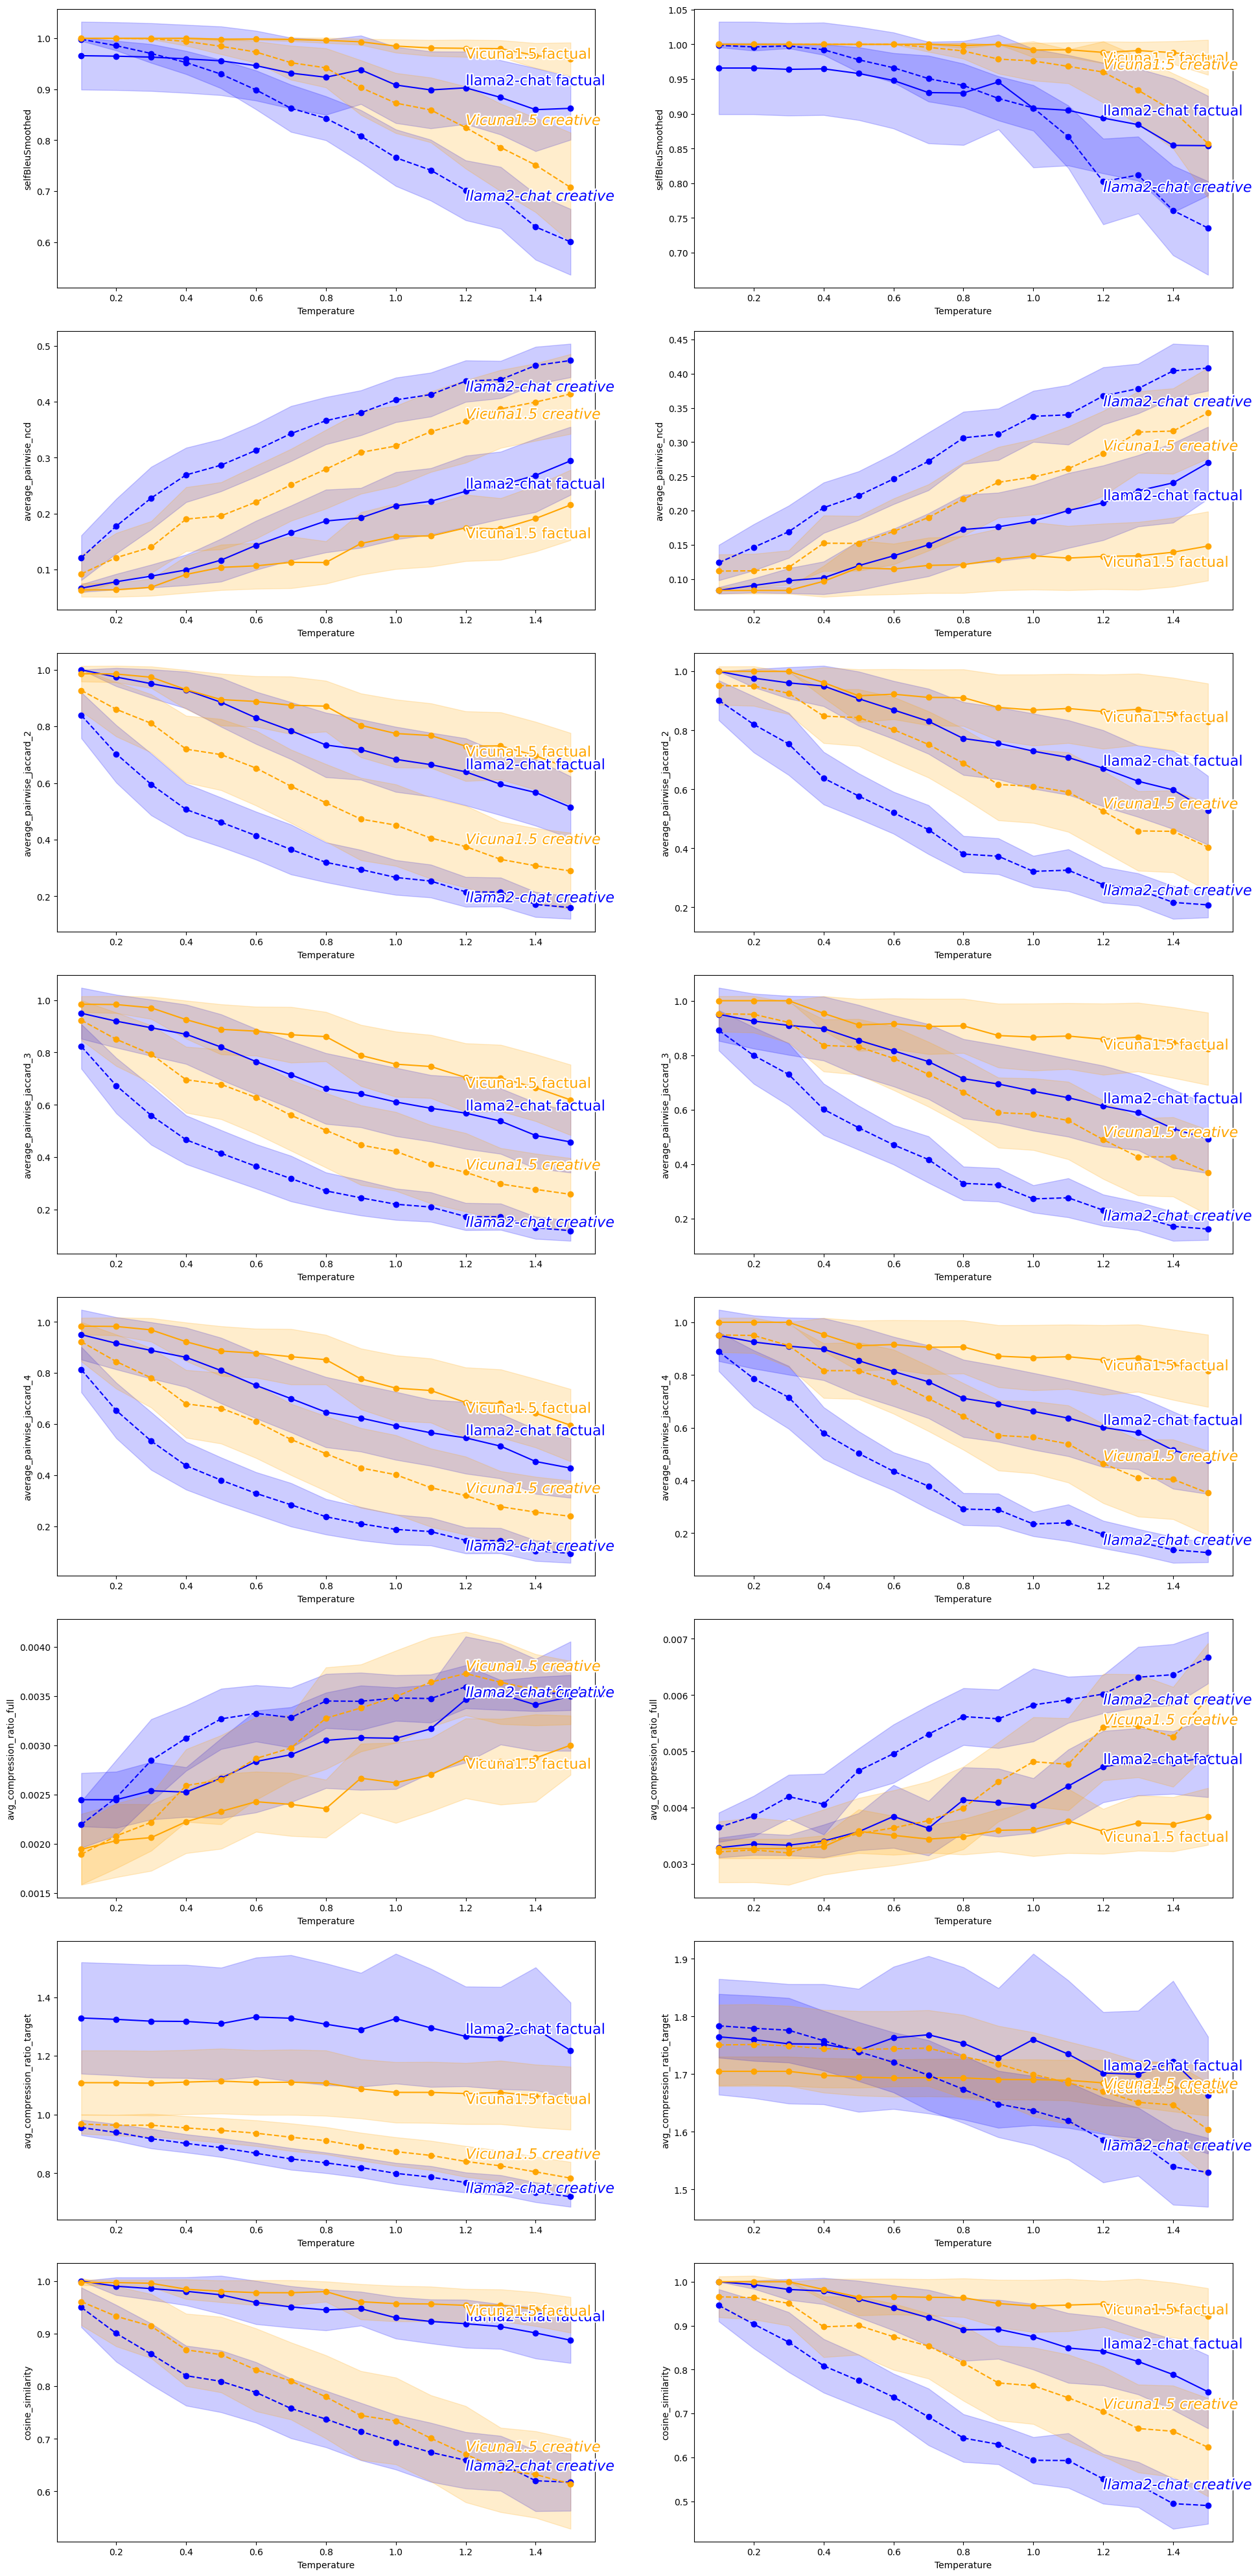

In [11]:
num_metrics = len(diversity_metrics.keys())
fig, axes = plt.subplots(num_metrics, 2, figsize=(20, 5*num_metrics))
# make font bigger
plt.rcParams.update({'font.size': 16})

text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]

i=0
for index, metric in enumerate(diversity_metrics.keys()):

    for col_idx, result in enumerate([results_20_words, results_5_words]):
        ax = axes[index, col_idx]

        scores_factual = result["factual"][metric]
        scores_creative = result["creative"][metric]

        # Plotting for factual scores
        ax.plot(temperatures, scores_factual[:, :, 0].mean(axis=1), label='llama2-chat', marker='o', color="blue")
        ax.fill_between(temperatures, scores_factual[:, :, 0].mean(axis=1) - 2 * scores_factual[:, :, 0].std(axis=1) / np.sqrt(scores_factual.shape[1]), 
                        scores_factual[:, :, 0].mean(axis=1) + 2 * scores_factual[:, :, 0].std(axis=1) / np.sqrt(scores_factual.shape[1]), alpha=0.2, color="blue")

        ax.plot(temperatures, scores_factual[:, :, 1].mean(axis=1), label='Vicuna1.5', marker='o', color="orange")
        ax.fill_between(temperatures, scores_factual[:, :, 1].mean(axis=1) - 2 * scores_factual[:, :, 1].std(axis=1) / np.sqrt(scores_factual.shape[1]), 
                        scores_factual[:, :, 1].mean(axis=1) + 2 * scores_factual[:, :, 1].std(axis=1) / np.sqrt(scores_factual.shape[1]), alpha=0.2, color="orange")

        # Plotting for creative scores
        ax.plot(temperatures, scores_creative[:, :, 0].mean(axis=1), label='llama2-chat creative', marker='o', linestyle='--', color="blue")
        ax.fill_between(temperatures, scores_creative[:, :, 0].mean(axis=1) - 2 * scores_creative[:, :, 0].std(axis=1) / np.sqrt(scores_creative.shape[1]), 
                        scores_creative[:, :, 0].mean(axis=1) + 2 * scores_creative[:, :, 0].std(axis=1) / np.sqrt(scores_creative.shape[1]), alpha=0.2, color="blue")

        ax.plot(temperatures, scores_creative[:, :, 1].mean(axis=1), label='Vicuna1.5 creative', marker='o', linestyle='--', color="orange")
        ax.fill_between(temperatures, scores_creative[:, :, 1].mean(axis=1) - 2 * scores_creative[:, :, 1].std(axis=1) / np.sqrt(scores_creative.shape[1]), 
                        scores_creative[:, :, 1].mean(axis=1) + 2 * scores_creative[:, :, 1].std(axis=1) / np.sqrt(scores_creative.shape[1]), alpha=0.2, color="orange")

        ax.set_xlabel('Temperature')
        ax.set_ylabel(metric)
        # ax.set_ylabel(metric_name[i])
        # ax.set_title(f'Diversity metric: {metric} for {20 if col_idx == 0 else 5} max words')
        #ax.legend()
        text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]

        # Add labels directly on the plot with white outline
        end_temp = temperatures[-4]
        text_factual1 = ax.text(end_temp, scores_factual[:, :, 0].mean(axis=1)[-4], 'llama2-chat factual', color='blue', verticalalignment='bottom')
        text_factual1.set_path_effects(text_effect)

        text_factual2 = ax.text(end_temp, scores_factual[:, :, 1].mean(axis=1)[-4], 'Vicuna1.5 factual', color='orange', verticalalignment='top')
        text_factual2.set_path_effects(text_effect)

        text_creative1 = ax.text(end_temp, scores_creative[:, :, 0].mean(axis=1)[-4], 'llama2-chat creative', color='blue', verticalalignment='top', style='italic')
        text_creative1.set_path_effects(text_effect)

        text_creative2 = ax.text(end_temp, scores_creative[:, :, 1].mean(axis=1)[-4], 'Vicuna1.5 creative', color='orange', verticalalignment='bottom', style='italic')
        text_creative2.set_path_effects(text_effect)
        i+=1


plt.tight_layout()
plt.show()

## How does the difference in diversity between creative and factual changes with temperature?

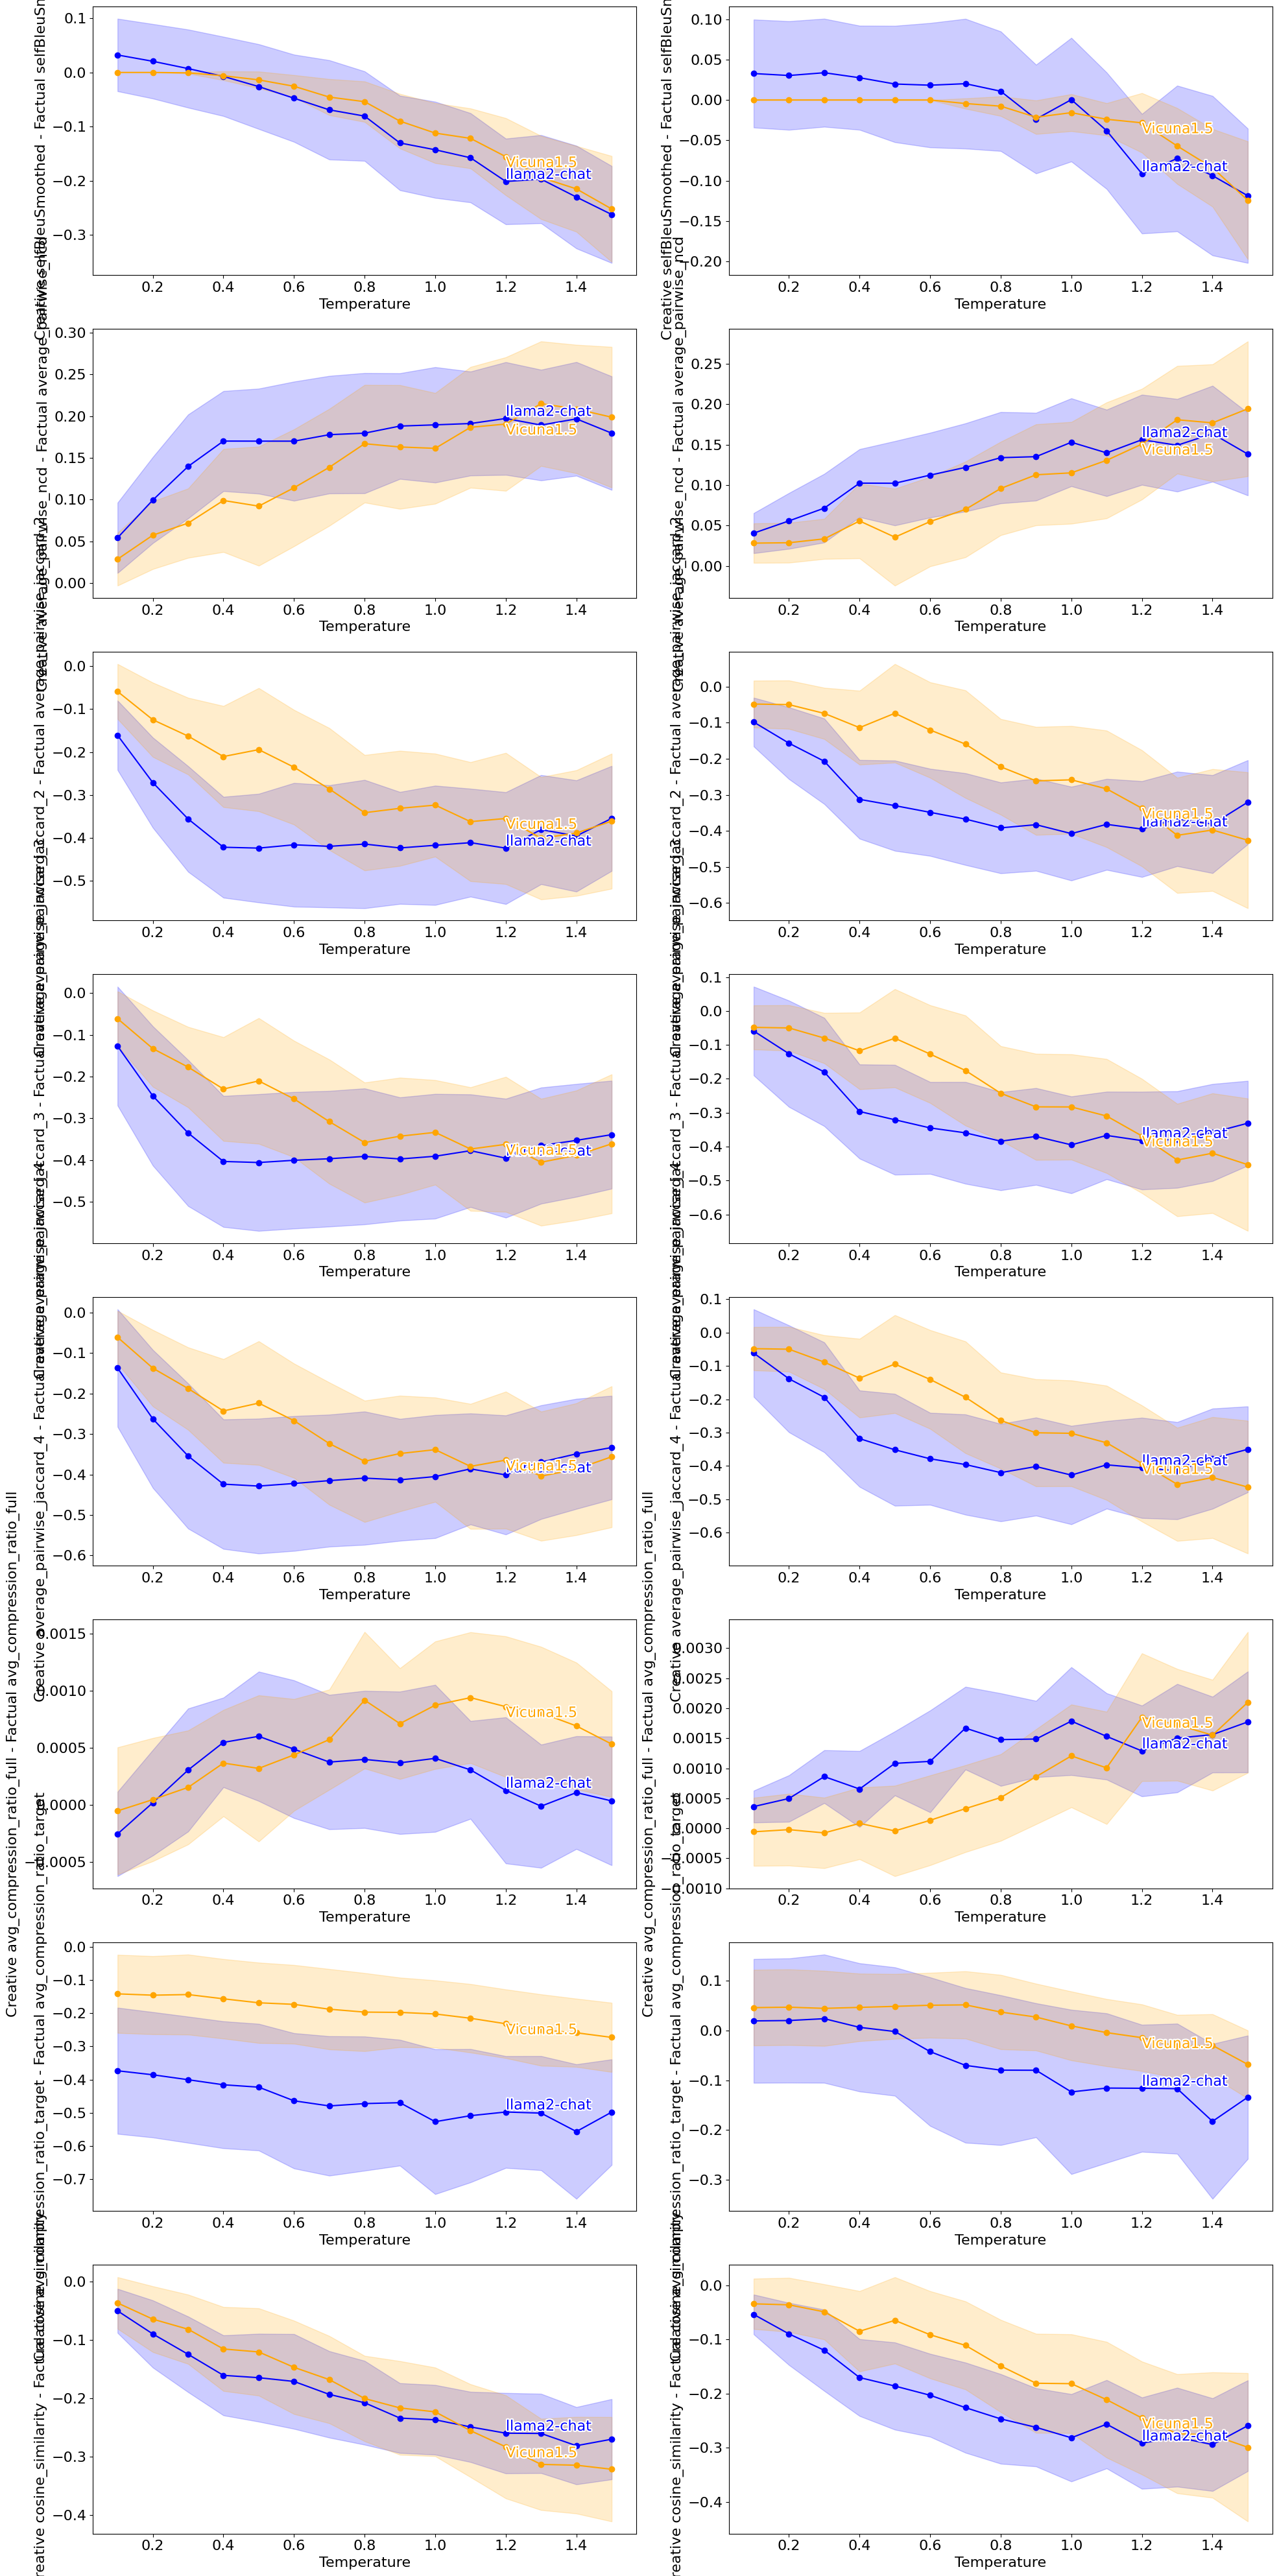

In [12]:
num_metrics = len(diversity_metrics.keys())
fig, axes = plt.subplots(num_metrics, 2, figsize=(20, 5*num_metrics))
# make font bigger
plt.rcParams.update({'font.size': 16})
text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]

i=0
for index, metric in enumerate(diversity_metrics.keys()):

    for col_idx, result in enumerate([results_20_words, results_5_words]):
        ax = axes[index, col_idx]

        scores_factual = result["factual"][metric]
        scores_creative = result["creative"][metric]

        # Calculate differences
        diff_llamaa = scores_creative[:, :, 0] - scores_factual[:, :, 0]
        diff_vicuna = scores_creative[:, :, 1] - scores_factual[:, :, 1]

        # Plotting differences
        ax.plot(temperatures, diff_llamaa.mean(axis=1), label='llama2-chat', marker='o', color="blue")
        ax.fill_between(temperatures, diff_llamaa.mean(axis=1) - 2 * diff_llamaa.std(axis=1) / np.sqrt(diff_llamaa.shape[1]), 
                        diff_llamaa.mean(axis=1) + 2 * diff_llamaa.std(axis=1) / np.sqrt(diff_llamaa.shape[1]), alpha=0.2, color="blue")

        ax.plot(temperatures, diff_vicuna.mean(axis=1), label='Vicuna1.5', marker='o', color="orange")
        ax.fill_between(temperatures, diff_vicuna.mean(axis=1) - 2 * diff_vicuna.std(axis=1) / np.sqrt(diff_vicuna.shape[1]), 
                        diff_vicuna.mean(axis=1) + 2 * diff_vicuna.std(axis=1) / np.sqrt(diff_vicuna.shape[1]), alpha=0.2, color="orange")

        end_temp = temperatures[-4]
        text_llama = ax.text(end_temp, diff_llamaa.mean(axis=1)[-4], 'llama2-chat', color='blue', verticalalignment='bottom')
        text_llama.set_path_effects(text_effect)

        text_vicuna = ax.text(end_temp, diff_vicuna.mean(axis=1)[-4], 'Vicuna1.5', color='orange', verticalalignment='top')
        text_vicuna.set_path_effects(text_effect)

        # ax.set_title(f"Metric: {metric} for Result {20 if col_idx == 0 else 5} max words")
        ax.set_xlabel("Temperature")
        ax.set_ylabel(f"Creative {metric} - Factual {metric}")
        i+=1

plt.tight_layout()
plt.show()